# TACO YOLO-NAS Train & Predict
https://www.kaggle.com/code/harpdeci/yolo-nas-ship-detection-aerial-images

https://github.com/Deci-AI/super-gradients<br/>
The new YOLO-NAS delivers state-of-the-art performance with the unparalleled accuracy-speed performance, outperforming other models such as YOLOv5, YOLOv6, YOLOv7 and YOLOv8.

In [1]:
%%capture
!pip install super-gradients==3.1.0
!pip install --upgrade pillow
!pip install --upgrade torchvision

In [2]:
import os
import random
import torch
import requests
from PIL import Image

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050

from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)

from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2023-06-03 04:21:09] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
import zipfile

def create_zip(source_folder, destination_zip):
    with zipfile.ZipFile(destination_zip, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zip_ref.write(file_path, arcname=os.path.relpath(file_path, source_folder))

def extract_zip(zip_file, destination_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

source_folder = '/kaggle/input/taco-data-downsized-for-yolo-nas'
destination_zip = '/kaggle/working/folder.zip'
destination_folder = '/kaggle/working/'

create_zip(source_folder, destination_zip)
extract_zip(destination_zip, destination_folder)

In [4]:
class config:
    #trainer params
    CHECKPOINT_DIR = 'checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'finding-battleships' #specify the experiment name
    #dataset params
    DATA_DIR = '/kaggle/working/datasets' #parent directory to where data lives
    TRAIN_IMAGES_DIR = 'train/images' #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = 'train/labels' #child dir of DATA_DIR where train labels are
    VAL_IMAGES_DIR = 'valid/images' #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = 'valid/labels' #child dir of DATA_DIR where validation labels are
    # if you have a test set
    TEST_IMAGES_DIR = 'test/images' #child dir of DATA_DIR where test images are
    TEST_LABELS_DIR = 'test/labels' #child dir of DATA_DIR where test labels are

    CLASSES = ['Aluminium foil', 'Bottle cap', 'Bottle', 'Broken glass', 'Can', 
               'Carton', 'Cigarette', 'Cup', 'Lid', 'Other litter', 'Other plastic', 
               'Paper', 'Plastic bag - wrapper', 'Plastic container', 'Pop tab', 
               'Straw', 'Styrofoam piece', 'Unlabeled litter']
 #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [5]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, 
                  ckpt_root_dir=config.CHECKPOINT_DIR)

In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TEST_IMAGES_DIR,
        'labels_dir': config.TEST_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

Caching annotations: 100%|██████████| 100/100 [00:00<00:00, 4018.34it/s]


# See train data

Caching annotations: 100%|██████████| 100/100 [00:00<00:00, 4183.59it/s]


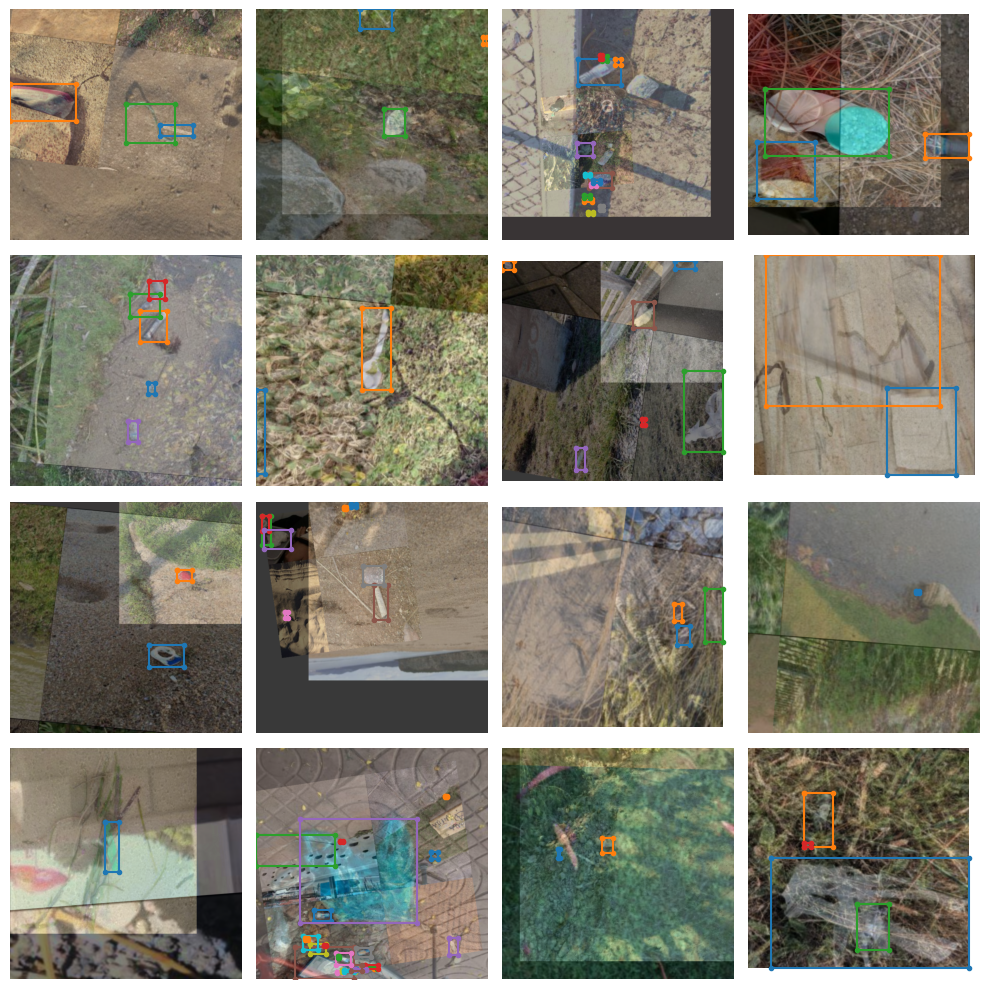

In [7]:
train_data.dataset.plot()

# Model

In [8]:
model = models.get(config.MODEL_NAME, 
                   num_classes=config.NUM_CLASSES, 
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2023-06-03 04:21:33] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
100%|██████████| 256M/256M [00:00<00:00, 280MB/s]


In [9]:
train_params = {
    # ENABLING SILENT MODE
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "AdamW",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 10,
    "mixed_precision": True, #mixed precision is not available for CPU 
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=config.NUM_CLASSES,
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=config.NUM_CLASSES,
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

# Train the model

In [10]:
trainer.train(model=model, 
              training_params=train_params, 
              train_loader=train_data, 
              valid_loader=val_data)

[2023-06-03 04:21:39] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/finding-battleships/console_Jun03_04_21_39.txt


[2023-06-03 04:21:42] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 300        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         18         (len(train_loader))
    - Gradient updates per epoch:   18         (len(train_loader) / batch_accumulate)

[2023-06-03 04:21:42] INFO - sg_trainer.py - Started training for 10 epochs (0/9)

Validation epoch 0: 100%|██████████| 6/6 [00:02<00:00,  2.04it/s]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.6964
│   ├── Ppyoloeloss/loss_cls = 2.3662
│   ├── Ppyoloeloss/loss_dfl = 1.333
│   └── Ppyoloeloss/loss_iou = 0.2654
└── Validation
    ├── F1@0.50 = 0.0
    ├── Map@0.50 = 0.0053
    ├── Ppyoloeloss/loss = 3.7826
    ├── Ppyoloeloss/loss_cls = 2.68
    ├── Ppyoloeloss/loss_dfl = 1.1895
    ├── Ppyoloeloss/loss_iou = 0.2031
    ├── Precision@0.50 = 0.0
    └── Recall@0.50 = 0.0



[2023-06-03 04:22:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-06-03 04:22:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.005317198112607002
Validation epoch 1: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 3.2706
│   │   ├── Best until now = 3.6964 (↘ -0.4258)
│   │   └── Epoch N-1      = 3.6964 (↘ -0.4258)
│   ├── Ppyoloeloss/loss_cls = 2.1051
│   │   ├── Best until now = 2.3662 (↘ -0.2611)
│   │   └── Epoch N-1      = 2.3662 (↘ -0.2611)
│   ├── Ppyoloeloss/loss_dfl = 1.151
│   │   ├── Best until now = 1.333  (↘ -0.182)
│   │   └── Epoch N-1      = 1.333  (↘ -0.182)
│   └── Ppyoloeloss/loss_iou = 0.236
│       ├── Best until now = 0.2654 (↘ -0.0295)
│       └── Epoch N-1      = 0.2654 (↘ -0.0295)
└── Validation
    ├── F1@0.50 = 0.007
    │   ├── Best until now = 0.0    (↗ 0.007)
    │   └── Epoch N-1      = 0.0    (↗ 0.007)
    ├── Map@0.50 = 0.0158
    │   ├── Best until now = 0.0053 (↗ 0.0105)
    │   └── Epoch N-1      = 0.0053 (↗ 0.0105)
    ├── Ppyoloeloss/loss = 4.1776
    │   ├── Best until now = 3.7826 (↗ 0.395)
    │   └── Epoch N-1      = 3.7826 (↗ 0.395)
    ├── Ppyoloeloss/loss_cls = 2.9131
    │   ├── Best until no

[2023-06-03 04:22:59] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-06-03 04:22:59] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.015771640464663506
Validation epoch 2: 100%|██████████| 6/6 [00:03<00:00,  1.88it/s]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 2.9743
│   │   ├── Best until now = 3.2706 (↘ -0.2963)
│   │   └── Epoch N-1      = 3.2706 (↘ -0.2963)
│   ├── Ppyoloeloss/loss_cls = 1.7658
│   │   ├── Best until now = 2.1051 (↘ -0.3393)
│   │   └── Epoch N-1      = 2.1051 (↘ -0.3393)
│   ├── Ppyoloeloss/loss_dfl = 1.1992
│   │   ├── Best until now = 1.151  (↗ 0.0482)
│   │   └── Epoch N-1      = 1.151  (↗ 0.0482)
│   └── Ppyoloeloss/loss_iou = 0.2436
│       ├── Best until now = 0.236  (↗ 0.0076)
│       └── Epoch N-1      = 0.236  (↗ 0.0076)
└── Validation
    ├── F1@0.50 = 0.0133
    │   ├── Best until now = 0.007  (↗ 0.0063)
    │   └── Epoch N-1      = 0.007  (↗ 0.0063)
    ├── Map@0.50 = 0.0101
    │   ├── Best until now = 0.0158 (↘ -0.0057)
    │   └── Epoch N-1      = 0.0158 (↘ -0.0057)
    ├── Ppyoloeloss/loss = 12.9465
    │   ├── Best until now = 3.7826 (↗ 9.1639)
    │   └── Epoch N-1      = 4.1776 (↗ 8.769)
    ├── Ppyoloeloss/loss_cls = 11.4547
    │   ├── Best 

Validation epoch 3: 100%|██████████| 6/6 [00:03<00:00,  2.00it/s]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 2.9343
│   │   ├── Best until now = 2.9743 (↘ -0.04)
│   │   └── Epoch N-1      = 2.9743 (↘ -0.04)
│   ├── Ppyoloeloss/loss_cls = 1.6592
│   │   ├── Best until now = 1.7658 (↘ -0.1066)
│   │   └── Epoch N-1      = 1.7658 (↘ -0.1066)
│   ├── Ppyoloeloss/loss_dfl = 1.2605
│   │   ├── Best until now = 1.151  (↗ 0.1094)
│   │   └── Epoch N-1      = 1.1992 (↗ 0.0613)
│   └── Ppyoloeloss/loss_iou = 0.2579
│       ├── Best until now = 0.236  (↗ 0.022)
│       └── Epoch N-1      = 0.2436 (↗ 0.0144)
└── Validation
    ├── F1@0.50 = 0.0056
    │   ├── Best until now = 0.0133 (↘ -0.0077)
    │   └── Epoch N-1      = 0.0133 (↘ -0.0077)
    ├── Map@0.50 = 0.0014
    │   ├── Best until now = 0.0158 (↘ -0.0144)
    │   └── Epoch N-1      = 0.0101 (↘ -0.0087)
    ├── Ppyoloeloss/loss = 719.357
    │   ├── Best until now = 3.7826 (↗ 715.5744)
    │   └── Epoch N-1      = 12.9465 (↗ 706.4104)
    ├── Ppyoloeloss/loss_cls = 715.2249
    │   ├── B

Validation epoch 4: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 2.9004
│   │   ├── Best until now = 2.9343 (↘ -0.0338)
│   │   └── Epoch N-1      = 2.9343 (↘ -0.0338)
│   ├── Ppyoloeloss/loss_cls = 1.6072
│   │   ├── Best until now = 1.6592 (↘ -0.0519)
│   │   └── Epoch N-1      = 1.6592 (↘ -0.0519)
│   ├── Ppyoloeloss/loss_dfl = 1.2721
│   │   ├── Best until now = 1.151  (↗ 0.1211)
│   │   └── Epoch N-1      = 1.2605 (↗ 0.0117)
│   └── Ppyoloeloss/loss_iou = 0.2629
│       ├── Best until now = 0.236  (↗ 0.0269)
│       └── Epoch N-1      = 0.2579 (↗ 0.0049)
└── Validation
    ├── F1@0.50 = 0.0162
    │   ├── Best until now = 0.0133 (↗ 0.0028)
    │   └── Epoch N-1      = 0.0056 (↗ 0.0105)
    ├── Map@0.50 = 0.0113
    │   ├── Best until now = 0.0158 (↘ -0.0044)
    │   └── Epoch N-1      = 0.0014 (↗ 0.01)
    ├── Ppyoloeloss/loss = 14.8984
    │   ├── Best until now = 3.7826 (↗ 11.1158)
    │   └── Epoch N-1      = 719.357 (↘ -704.4585)
    ├── Ppyoloeloss/loss_cls = 13.4533
    │   ├── Be

Validation epoch 5: 100%|██████████| 6/6 [00:02<00:00,  2.02it/s]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 2.8345
│   │   ├── Best until now = 2.9004 (↘ -0.0659)
│   │   └── Epoch N-1      = 2.9004 (↘ -0.0659)
│   ├── Ppyoloeloss/loss_cls = 1.5791
│   │   ├── Best until now = 1.6072 (↘ -0.0281)
│   │   └── Epoch N-1      = 1.6072 (↘ -0.0281)
│   ├── Ppyoloeloss/loss_dfl = 1.2307
│   │   ├── Best until now = 1.151  (↗ 0.0797)
│   │   └── Epoch N-1      = 1.2721 (↘ -0.0414)
│   └── Ppyoloeloss/loss_iou = 0.256
│       ├── Best until now = 0.236  (↗ 0.02)
│       └── Epoch N-1      = 0.2629 (↘ -0.0068)
└── Validation
    ├── F1@0.50 = 0.0088
    │   ├── Best until now = 0.0162 (↘ -0.0074)
    │   └── Epoch N-1      = 0.0162 (↘ -0.0074)
    ├── Map@0.50 = 0.0208
    │   ├── Best until now = 0.0158 (↗ 0.0051)
    │   └── Epoch N-1      = 0.0113 (↗ 0.0095)
    ├── Ppyoloeloss/loss = 8.6264
    │   ├── Best until now = 3.7826 (↗ 4.8438)
    │   └── Epoch N-1      = 14.8984 (↘ -6.272)
    ├── Ppyoloeloss/loss_cls = 7.3384
    │   ├── Best u

[2023-06-03 04:25:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-06-03 04:25:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.020835187286138535
Validation epoch 6: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 2.7636
│   │   ├── Best until now = 2.8345 (↘ -0.0709)
│   │   └── Epoch N-1      = 2.8345 (↘ -0.0709)
│   ├── Ppyoloeloss/loss_cls = 1.5663
│   │   ├── Best until now = 1.5791 (↘ -0.0128)
│   │   └── Epoch N-1      = 1.5791 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_dfl = 1.1825
│   │   ├── Best until now = 1.151  (↗ 0.0315)
│   │   └── Epoch N-1      = 1.2307 (↘ -0.0482)
│   └── Ppyoloeloss/loss_iou = 0.2424
│       ├── Best until now = 0.236  (↗ 0.0065)
│       └── Epoch N-1      = 0.256  (↘ -0.0136)
└── Validation
    ├── F1@0.50 = 0.0091
    │   ├── Best until now = 0.0162 (↘ -0.0071)
    │   └── Epoch N-1      = 0.0088 (↗ 0.0003)
    ├── Map@0.50 = 0.0217
    │   ├── Best until now = 0.0208 (↗ 0.0009)
    │   └── Epoch N-1      = 0.0208 (↗ 0.0009)
    ├── Ppyoloeloss/loss = 4.6715
    │   ├── Best until now = 3.7826 (↗ 0.8889)
    │   └── Epoch N-1      = 8.6264 (↘ -3.9549)
    ├── Ppyoloeloss/loss_cls = 3.438
    │   ├── Best 

[2023-06-03 04:26:26] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-06-03 04:26:26] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.021723801270127296
Validation epoch 7: 100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 2.6614
│   │   ├── Best until now = 2.7636 (↘ -0.1021)
│   │   └── Epoch N-1      = 2.7636 (↘ -0.1021)
│   ├── Ppyoloeloss/loss_cls = 1.5401
│   │   ├── Best until now = 1.5663 (↘ -0.0261)
│   │   └── Epoch N-1      = 1.5663 (↘ -0.0261)
│   ├── Ppyoloeloss/loss_dfl = 1.1198
│   │   ├── Best until now = 1.151  (↘ -0.0312)
│   │   └── Epoch N-1      = 1.1825 (↘ -0.0627)
│   └── Ppyoloeloss/loss_iou = 0.2246
│       ├── Best until now = 0.236  (↘ -0.0114)
│       └── Epoch N-1      = 0.2424 (↘ -0.0179)
└── Validation
    ├── F1@0.50 = 0.0123
    │   ├── Best until now = 0.0162 (↘ -0.0039)
    │   └── Epoch N-1      = 0.0091 (↗ 0.0032)
    ├── Map@0.50 = 0.0297
    │   ├── Best until now = 0.0217 (↗ 0.008)
    │   └── Epoch N-1      = 0.0217 (↗ 0.008)
    ├── Ppyoloeloss/loss = 3.6982
    │   ├── Best until now = 3.7826 (↘ -0.0844)
    │   └── Epoch N-1      = 4.6715 (↘ -0.9733)
    ├── Ppyoloeloss/loss_cls = 2.5326
    │   ├── Bes

[2023-06-03 04:27:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-06-03 04:27:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.02973359078168869
Validation epoch 8: 100%|██████████| 6/6 [00:03<00:00,  1.69it/s]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 2.5942
│   │   ├── Best until now = 2.6614 (↘ -0.0672)
│   │   └── Epoch N-1      = 2.6614 (↘ -0.0672)
│   ├── Ppyoloeloss/loss_cls = 1.462
│   │   ├── Best until now = 1.5401 (↘ -0.0781)
│   │   └── Epoch N-1      = 1.5401 (↘ -0.0781)
│   ├── Ppyoloeloss/loss_dfl = 1.1393
│   │   ├── Best until now = 1.1198 (↗ 0.0194)
│   │   └── Epoch N-1      = 1.1198 (↗ 0.0194)
│   └── Ppyoloeloss/loss_iou = 0.225
│       ├── Best until now = 0.2246 (↗ 0.0005)
│       └── Epoch N-1      = 0.2246 (↗ 0.0005)
└── Validation
    ├── F1@0.50 = 0.0139
    │   ├── Best until now = 0.0162 (↘ -0.0023)
    │   └── Epoch N-1      = 0.0123 (↗ 0.0016)
    ├── Map@0.50 = 0.0268
    │   ├── Best until now = 0.0297 (↘ -0.0029)
    │   └── Epoch N-1      = 0.0297 (↘ -0.0029)
    ├── Ppyoloeloss/loss = 3.2093
    │   ├── Best until now = 3.6982 (↘ -0.4889)
    │   └── Epoch N-1      = 3.6982 (↘ -0.4889)
    ├── Ppyoloeloss/loss_cls = 2.0347
    │   ├── Best 

Validation epoch 9: 100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 2.6238
│   │   ├── Best until now = 2.5942 (↗ 0.0296)
│   │   └── Epoch N-1      = 2.5942 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_cls = 1.4892
│   │   ├── Best until now = 1.462  (↗ 0.0272)
│   │   └── Epoch N-1      = 1.462  (↗ 0.0272)
│   ├── Ppyoloeloss/loss_dfl = 1.1411
│   │   ├── Best until now = 1.1198 (↗ 0.0212)
│   │   └── Epoch N-1      = 1.1393 (↗ 0.0018)
│   └── Ppyoloeloss/loss_iou = 0.2256
│       ├── Best until now = 0.2246 (↗ 0.0011)
│       └── Epoch N-1      = 0.225  (↗ 0.0006)
└── Validation
    ├── F1@0.50 = 0.0161
    │   ├── Best until now = 0.0162 (↘ -0.0001)
    │   └── Epoch N-1      = 0.0139 (↗ 0.0022)
    ├── Map@0.50 = 0.041
    │   ├── Best until now = 0.0297 (↗ 0.0113)
    │   └── Epoch N-1      = 0.0268 (↗ 0.0142)
    ├── Ppyoloeloss/loss = 2.8553
    │   ├── Best until now = 3.2093 (↘ -0.354)
    │   └── Epoch N-1      = 3.2093 (↘ -0.354)
    ├── Ppyoloeloss/loss_cls = 1.7573
    │   ├── Best until n

[2023-06-03 04:28:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/finding-battleships/ckpt_best.pth
[2023-06-03 04:28:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50: 0.04103395715355873
[2023-06-03 04:29:21] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 10: 100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 2.6238
│   │   ├── Best until now = 2.5942 (↗ 0.0296)
│   │   └── Epoch N-1      = 2.5942 (↗ 0.0296)
│   ├── Ppyoloeloss/loss_cls = 1.4892
│   │   ├── Best until now = 1.462  (↗ 0.0272)
│   │   └── Epoch N-1      = 1.462  (↗ 0.0272)
│   ├── Ppyoloeloss/loss_dfl = 1.1411
│   │   ├── Best until now = 1.1198 (↗ 0.0212)
│   │   └── Epoch N-1      = 1.1393 (↗ 0.0018)
│   └── Ppyoloeloss/loss_iou = 0.2256
│       ├── Best until now = 0.2246 (↗ 0.0011)
│       └── Epoch N-1      = 0.225  (↗ 0.0006)
└── Validation
    ├── F1@0.50 = 0.0267
    │   ├── Best until now = 0.0162 (↗ 0.0105)
    │   └── Epoch N-1      = 0.0161 (↗ 0.0107)
    ├── Map@0.50 = 0.0373
    │   ├── Best until now = 0.041  (↘ -0.0037)
    │   └── Epoch N-1      = 0.041  (↘ -0.0037)
    ├── Ppyoloeloss/loss = 2.9227
    │   ├── Best until now = 2.8553 (↗ 0.0674)
    │   └── Epoch N-1      = 2.8553 (↗ 0.0674)
    ├── Ppyoloeloss/loss_cls = 1.8563
    │   ├── Best unti

In [11]:
best_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(config.CHECKPOINT_DIR, config.EXPERIMENT_NAME, 'average_model.pth'))

[2023-06-03 04:29:28] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


In [12]:
trainer.test(model=best_model,
            test_loader=test_data,
            test_metrics_list=DetectionMetrics_050(score_thres=0.1, 
               top_k_predictions=300, 
               num_cls=config.NUM_CLASSES, 
               normalize_targets=True, 
               post_prediction_callback=PPYoloEPostPredictionCallback(
                  score_threshold=0.01, 
                  nms_top_k=1000, 
                  max_predictions=300,
                  nms_threshold=0.7)
               ))

[2023-06-03 04:29:30] INFO - checkpoint_utils.py - Successfully loaded model weights from checkpoints/finding-battleships/average_model.pth EMA checkpoint.
Test: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


{'PPYoloELoss/loss_cls': 1.6875318,
 'PPYoloELoss/loss_iou': 0.20707357,
 'PPYoloELoss/loss_dfl': 1.0209699,
 'PPYoloELoss/loss': 2.7157004,
 'Precision@0.50': tensor(0.0089),
 'Recall@0.50': tensor(0.4454),
 'mAP@0.50': tensor(0.1073),
 'F1@0.50': tensor(0.0172)}

In [13]:
tpaths=[]
for dirname, _, filenames in os.walk('/kaggle/input/taco-data-downsized-for-yolo-nas/datasets/test/images'):
    for filename in filenames:
        tpaths+=[(os.path.join(dirname, filename))]
tpaths2=random.sample(tpaths,10)

# Test Prediction

Predicting Images: 100%|██████████| 10/10 [00:16<00:00,  1.65s/it]


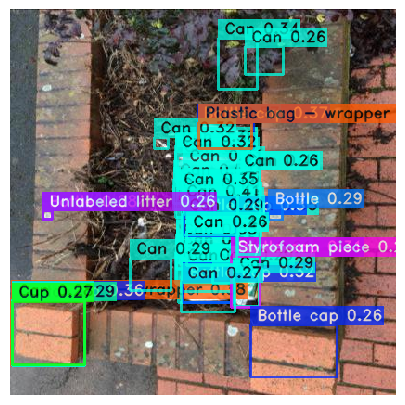

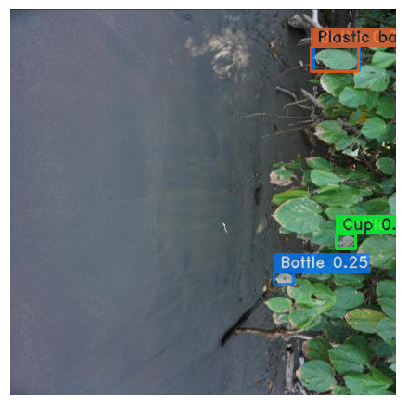

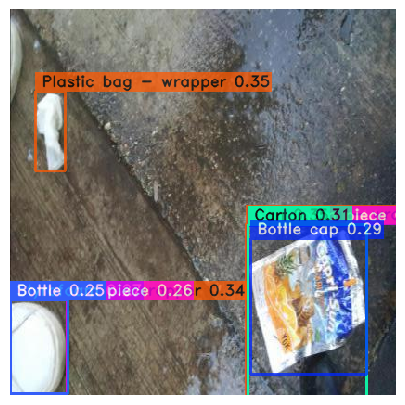

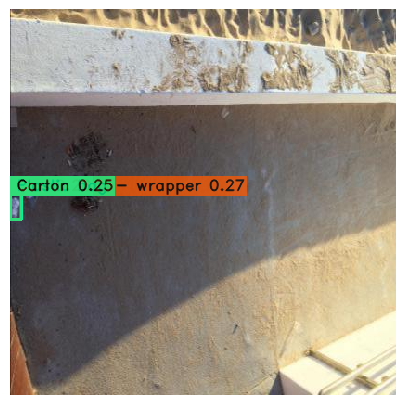

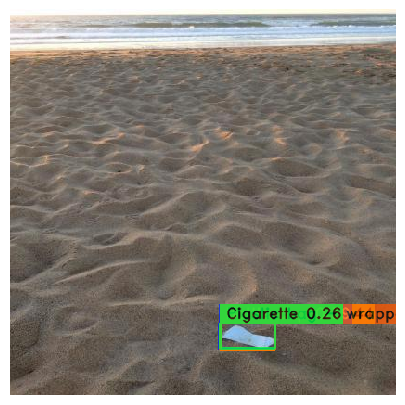

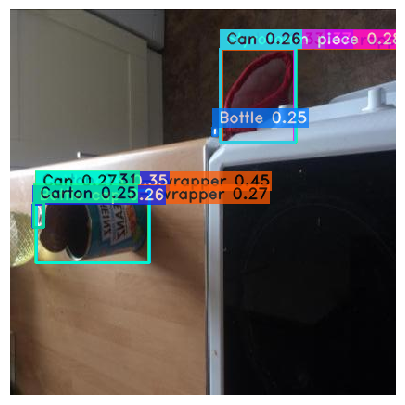

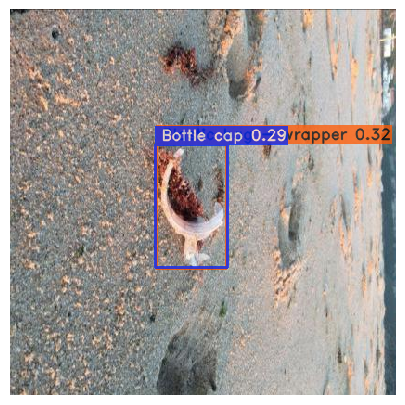

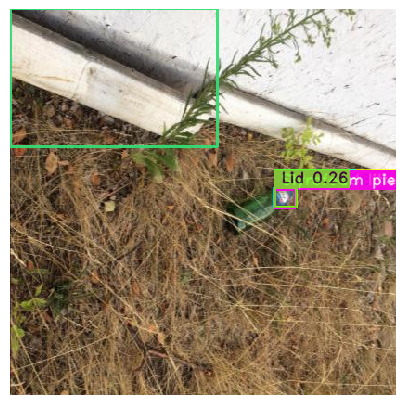

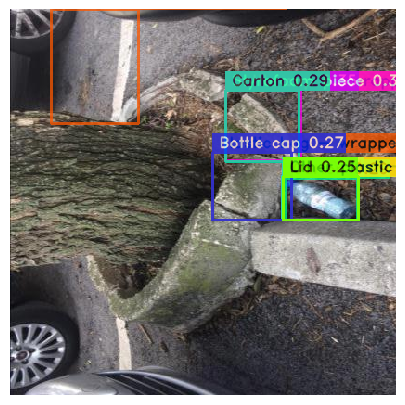

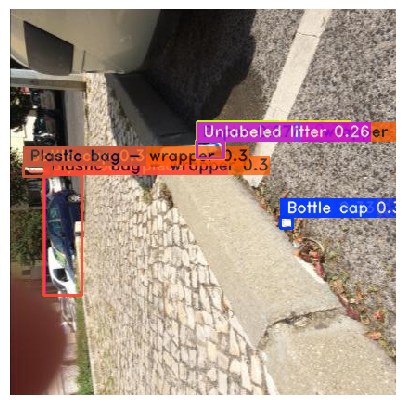

In [14]:
best_model.predict(tpaths2, conf=0.25).show()